In [1]:
import glob
import os
import re

import h5py
import numpy as np
import pandas as pd
import pybedtools
from scipy.stats import pearsonr, spearmanr, wilcoxon
from sklearn.metrics import roc_auc_score, average_precision_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.25, style='ticks')


In [2]:
#Define folders with variant effect predictions

borzoi_dir = '/home/drk/seqnn/data/models/v2'
borzoi_eqtl_dir = '%s/ensemble/gtexu' % borzoi_dir

enform_eqtl_dir = '/home/drk/attn/analysis/2020/8-13/dm37_out'

In [3]:
#Accumulate Borzoi logD2 predictions

borzoi_preds = {}
pattern = r"/([^/]+)_class"

#Loop over files
for preds_file in glob.glob('%s/*_class-logD2/preds.npy' % borzoi_eqtl_dir):
    tissue = re.search(pattern, preds_file).group(1)
    borzoi_preds[tissue] = np.load(preds_file)

len(borzoi_preds)


49

In [4]:
#Accumulate Enformer SAD predictions

enform_preds = {}

#Loop over files
for preds_file in glob.glob('%s/*_class-sad/preds.npy' % enform_eqtl_dir):
    tissue = preds_file.split('/')[-2][:-10]
    enform_preds[tissue] = np.load(preds_file)

len(enform_preds)


49

In [5]:
#Get set of tissues

tissues = set(borzoi_preds.keys()) & set(enform_preds.keys())
len(tissues)


49

In [8]:
#Compute variant distances

tissue_nvariant_dist = {}
tissue_pvariant_dist = {}

#Loop over tissues
for tissue in tissues:
    
    #Load TSS annotation
    genes_file = '/home/drk/common/data/genomes/hg38/genes/gencode38/gencode38_basic_protein_tss2.bed'
    genes_bt = pybedtools.BedTool(genes_file)

    #Load VCF file (pos)
    vcf_pos_file = '/home/drk/seqnn/data/gtex_fine/susie_pip90/%s_pos.vcf' % tissue
    vcf_pos_bt = pybedtools.BedTool(vcf_pos_file)
    variant_pos_order = [vc[2] for vc in vcf_pos_bt]
    vcf_pos_bt = vcf_pos_bt.sort(header=True)

    #Calculate distance of each SNP to the closest TSS
    variant_pos_dist_hash = {}
    for vc in vcf_pos_bt.closest(genes_bt, d=True, t='first'):
        variant_pos_dist_hash[vc[2]] = int(vc[-1])
    variant_pos_dist = np.array([variant_pos_dist_hash[v] for v in variant_pos_order])
    tissue_pvariant_dist[tissue] = np.log1p(variant_pos_dist)

    #Load VCF file (neg)
    vcf_neg_file = '/home/drk/seqnn/data/gtex_fine/susie_pip90/%s_neg.vcf' % tissue
    vcf_neg_bt = pybedtools.BedTool(vcf_neg_file)
    variant_neg_order = [vc[2] for vc in vcf_neg_bt]
    vcf_neg_bt = vcf_neg_bt.sort(header=True)

    #Calculate distance of each SNP to the closest TSS
    variant_neg_dist_hash = {}
    for vc in vcf_neg_bt.closest(genes_bt, d=True, t='first'):
        variant_neg_dist_hash[vc[2]] = int(vc[-1])
    variant_neg_dist = np.array([variant_neg_dist_hash[v] for v in variant_neg_order])
    tissue_nvariant_dist[tissue] = np.log1p(variant_neg_dist)


## AUROC in bins

In [9]:
#Get vector of distances

variant_dist = np.concatenate([variant_pos_dist, variant_neg_dist])
variant_dist.shape


(4318,)

In [10]:
#Compute binned AUROCs and AUPRCs

tissue_bin_df = []
auroc_bin_df = []
ap_bin_df = []
model_bin_df = []
label_bin_df = []

#Define bin boundaries
bin_bounds = np.log1p([0, 3000, 12000, 35000, 200000])

#Loop over tissues
for tissue in tissues:
    
    #Get Borzoi and Enformer predictions
    borzoi_upreds = borzoi_preds[tissue].mean(axis=1)
    enform_upreds = enform_preds[tissue].mean(axis=1)
    
    #Define labels and number of variants
    num_variants = borzoi_upreds.shape[0]
    num_variants_pos = num_variants // 2
    variant_labels = [np.ones(num_variants_pos), np.zeros(num_variants_pos)]
    variant_labels = np.concatenate(variant_labels)

    #Get vector of distances per tissue
    variant_pos_dist = tissue_pvariant_dist[tissue]
    variant_neg_dist = tissue_nvariant_dist[tissue]
    variant_dist = np.concatenate([variant_pos_dist, variant_neg_dist])
    
    #Loop over boundaries
    for bi in range(1,len(bin_bounds)):
        
        #Get mask with predictions within distance bin
        bin_mask = (variant_dist >= bin_bounds[bi-1]) & (variant_dist < bin_bounds[bi])
        
        #Calculate AUROCs
        borzoi_auroc_bin = roc_auc_score(variant_labels[bin_mask], borzoi_upreds[bin_mask])
        enform_auroc_bin = roc_auc_score(variant_labels[bin_mask], enform_upreds[bin_mask])
        
        #Calculate AUPRCs
        borzoi_ap_bin = average_precision_score(variant_labels[bin_mask], borzoi_upreds[bin_mask])
        enform_ap_bin = average_precision_score(variant_labels[bin_mask], enform_upreds[bin_mask])

        #Get bins
        bin_left = int(np.round(np.expm1(bin_bounds[bi-1])))
        bin_right = int(np.round(np.expm1(bin_bounds[bi])))

        if bi == 1:
            bin_label = '<%d' % bin_right
        elif bi == len(bin_bounds)-1:
            bin_label = '>%d' % bin_left
        else:
            bin_label = '%d-%d' % (bin_left, bin_right)

        #Record Borzoi metrics
        tissue_bin_df.append(tissue)
        model_bin_df.append('Borzoi')
        label_bin_df.append(bin_label)
        auroc_bin_df.append(borzoi_auroc_bin)
        ap_bin_df.append(borzoi_ap_bin)
        
        #Record Enformer metrics
        tissue_bin_df.append(tissue)
        model_bin_df.append('Enformer')
        label_bin_df.append(bin_label)
        auroc_bin_df.append(enform_auroc_bin)
        ap_bin_df.append(enform_ap_bin)

#Construct dataframe
df = pd.DataFrame({
    'Tissue':tissue_bin_df,
    'Model':model_bin_df,
    'Bin':label_bin_df,
    'auROC':auroc_bin_df,
    'auPRC':ap_bin_df
})
df


,Tissue,Model,Bin,auROC,auPRC
0,Liver,Borzoi,<3000,0.810953,0.887000
1,Liver,Enformer,<3000,0.785071,0.915141
2,Liver,Borzoi,3000-12000,0.827315,0.824322
3,Liver,Enformer,3000-12000,0.742438,0.717871
4,Liver,Borzoi,12000-35000,0.777660,0.743927
...,...,...,...,...,...
387,Adipose_Subcutaneous,Enformer,3000-12000,0.700132,0.697438
388,Adipose_Subcutaneous,Borzoi,12000-35000,0.757484,0.720162
389,Adipose_Subcutaneous,Enformer,12000-35000,0.691293,0.650487
390,Adipose_Subcutaneous,Borzoi,>35000,0.783698,0.721844


(0.5, 0.9674122444902932)

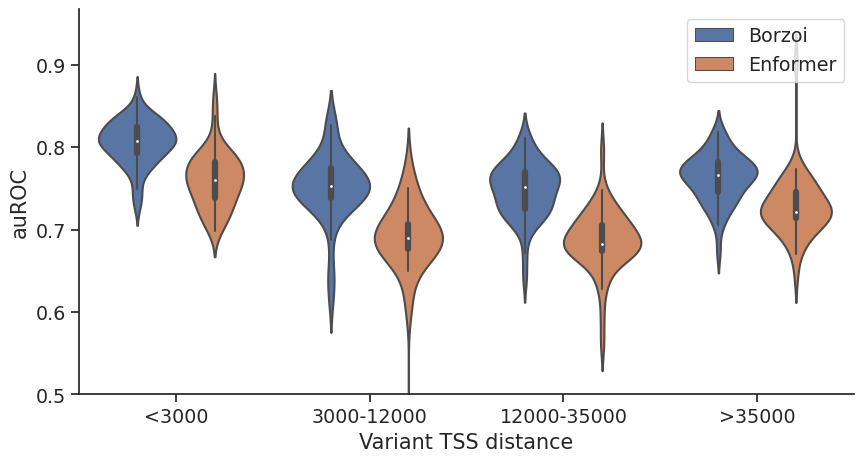

In [11]:
#Plot AUROC distributions (Borzoi vs Enformer)

plt.figure(figsize=(10,5))
sns.violinplot(x='Bin', y='auROC', hue='Model', data=df)
sns.despine()
plt.gca().legend(loc='upper right')
plt.gca().set_xlabel('Variant TSS distance')
plt.gca().set_ylim(0.5,None)
# plt.savefig('eqtl_dist_auroc.pdf')


In [12]:
#Plot summary statistics
print('%12s %8s %8s %7s' % ('Distance', 'Borzoi', 'Enformer', 'p-value'))

#Loop over bins
for dist_bin in df.Bin.unique():
    df_bin = df[df.Bin == dist_bin]
    auroc_borzoi = df_bin[df_bin.Model=='Borzoi'].auROC
    auroc_enformer = df_bin[df_bin.Model=='Enformer'].auROC
    z, p = wilcoxon(auroc_borzoi, auroc_enformer)
    print('%12s   %.4f  %.4f  %.1e' % (dist_bin, auroc_borzoi.mean(), auroc_enformer.mean(), p))


    Distance   Borzoi Enformer p-value
       <3000   0.8054  0.7600  6.2e-12
  3000-12000   0.7508  0.6873  1.5e-13
 12000-35000   0.7485  0.6869  3.6e-15
      >35000   0.7628  0.7276  1.6e-09


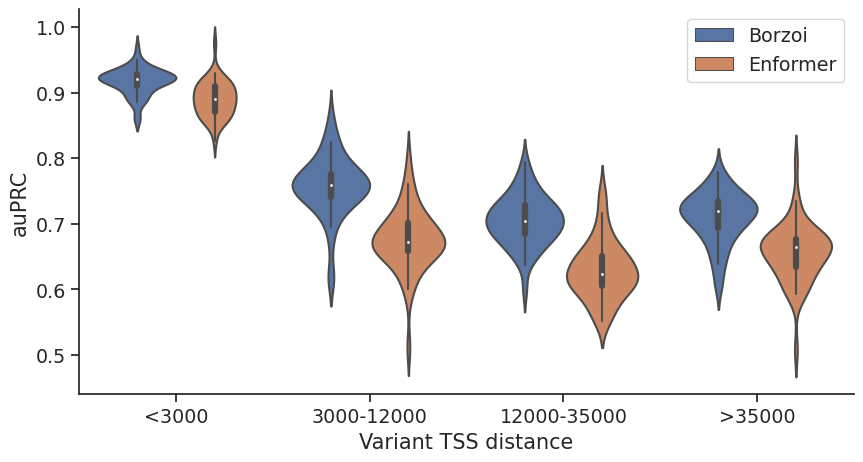

In [16]:
#Plot AUPRC distributions (Borzoi vs Enformer)

plt.figure(figsize=(10,5))
sns.violinplot(x='Bin', y='auPRC', hue='Model', data=df)
sns.despine()
plt.gca().legend(loc='upper right')
plt.gca().set_xlabel('Variant TSS distance')
# plt.gca().set_ylim(0.5,None)
plt.savefig('eqtl_dist_auprc.pdf')


In [15]:
#Plot summary statistics
print('%12s %8s %8s %7s' % ('Distance', 'Borzoi', 'Enformer', 'p-value'))

#Loop over bins
for dist_bin in df.Bin.unique():
    df_bin = df[df.Bin == dist_bin]
    auroc_borzoi = df_bin[df_bin.Model=='Borzoi'].auPRC
    auroc_enformer = df_bin[df_bin.Model=='Enformer'].auPRC
    z, p = wilcoxon(auroc_borzoi, auroc_enformer)
    print('%12s   %.4f  %.4f  %.1e' % (dist_bin, auroc_borzoi.mean(), auroc_enformer.mean(), p))


    Distance   Borzoi Enformer p-value
       <3000   0.9172  0.8898  4.7e-09
  3000-12000   0.7576  0.6759  2.5e-14
 12000-35000   0.7052  0.6289  3.6e-15
      >35000   0.7101  0.6561  2.0e-10
